In [133]:
import torch
import torch.nn as nn
import torch.optim as optim
import json
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

df = pd.read_parquet(r'C:\Users\drpla\Desktop\ICL-PHYSICS-YEAR-4\Masters Project\Data\New folder\merged_nominal.parquet')

with open(r'C:\Users\drpla\Desktop\ICL-PHYSICS-YEAR-4\Masters Project\Data\New folder\summary.json', "r") as f:
  proc_dict = json.load(f)["sample_id_map"]
  
  
sig = df[df.process_id == proc_dict["GluGluToRadionToHHTo2G2Tau_M-300"]] # just one signal process, mass of X is 1000 GeV
sig['Classification']=np.ones(sig['Diphoton_mass'].size)
#bkg = df[df.process_id == proc_dict["DiPhoton"]] # just one of the background processes

C:\Users\drpla\AppData\Local\Temp\ipykernel_32228\2174124729.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig['Classification']=np.ones(sig['Diphoton_mass'].size)


In [134]:
"""Concatenating the background data"""
background_list=['Data','DiPhoton', 'TTGG', 'TTGamma',#list of each bkgs for concatenation
 'TTJets',
 'VBFH_M125',
 'VH_M125',
 'WGamma',
 'ZGamma',
 'ggH_M125', 
 'ttH_M125',
 'GJets']

listforconc=[]
for i in background_list:                               #creating a concatenated list of bkg
    bkgg = df[df.process_id == proc_dict[i]]
    listforconc.append(bkgg)
    
background = pd.concat(listforconc)
background['Classification']=np.zeros(background['Diphoton_mass'].size)

In [135]:
"""Concatenating Signal and Background"""
"""Choosing Best Features given the M=1000 AUC scores"""
FullSignalBackground=pd.concat([sig,background])

df_TopFeatures=pd.DataFrame()
TopFeatures=['reco_MX_mgg','Diphoton_pt_mgg','LeadPhoton_pt_mgg','ditau_pt','Diphoton_dPhi','dilep_leadpho_mass','lead_lepton_pt','MET_pt','ditau_dR','SubleadPhoton_pt_mgg','weight_central','Classification']
for feature in TopFeatures:
    df_TopFeatures[feature]=FullSignalBackground[feature]
    
    
features = df_TopFeatures.drop(columns=['Classification'])  # Extracting features
labels = df_TopFeatures['Classification']  # Extracting labels

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=(1/3), random_state=42)
test_weights=pd.DataFrame()
train_weights=pd.DataFrame()
train_weights['weight_central']=train_features['weight_central']
test_weights['weight_central']=test_features['weight_central']

train_features=train_features.drop(columns=['weight_central'])
test_features=test_features.drop(columns=['weight_central'])

train_features_tensor = torch.tensor(train_features.values, dtype=torch.float32)
train_weights_tensor = torch.tensor(train_weights.values,dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values,dtype=torch.float32)


In [136]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Input layer to hidden layer
        self.relu1 = nn.ReLU()  # Activation function
        self.fc2 = nn.Linear(hidden_size, output_size)  # Hidden layer to output layer
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x
    


def weightedBCELoss(input, target, weight):
  x, y, w = input, target, weight
  log = lambda x: torch.log(x*(1-1e-8) + 1e-8)
  return torch.mean(-w * (y*log(x) + (1-y)*log(1-x)))

In [137]:
model = SimpleNN(10,20,1)

In [138]:
trained=model.forward(train_features_tensor)

623536 623536


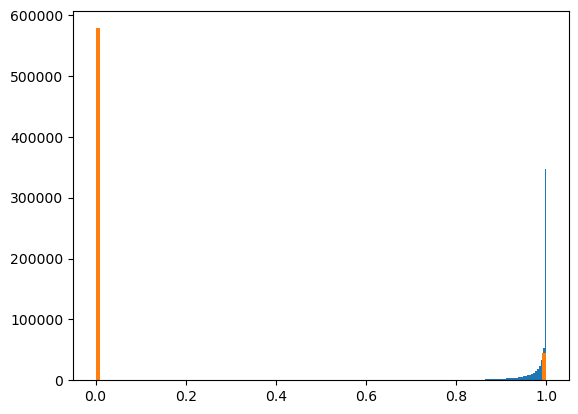

In [145]:
plt.hist(trained.squeeze().tolist(),bins=100)
plt.hist(train_labels_tensor.squeeze().tolist(),bins=100)


In [152]:
#epoch=5
#for i in range(0,epoch):
 #   trained = model.forward(train_features_tensor)


In [153]:
trained


tensor([[0.8556],
        [0.9968],
        [0.9979],
        ...,
        [0.9732],
        [0.9383],
        [0.9055]], grad_fn=<SigmoidBackward0>)

In [154]:
data = trained.squeeze().tolist()  # Replace with your dataset

chunk_size = 1000  # Define the chunk size

# Process data in chunks
for i in range(0, len(data), chunk_size):
    chunk = data[i:i+chunk_size]  # Get a chunk of data
   # print('Processed Chunk', len(chunk))  # Process the chunk
HELPPPPPP


NameError: name 'HELPPPPPP' is not defined

In [156]:
error = weightedBCELoss(trained, train_labels_tensor, train_weights_tensor)

RuntimeError: [enforce fail at alloc_cpu.cpp:80] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1555188573184 bytes.